In [2]:
!pip install kaggle
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install polars
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os
import shutil

source = r"C:\Users\User\Downloads\kaggle.json"
destination = r"C:\Users\User\.kaggle\kaggle.json"

os.makedirs(os.path.dirname(destination), exist_ok=True)
shutil.move(source, destination)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
!kaggle competitions download -c home-credit-credit-risk-model-stability


  0%|          | 0.00/3.14G [00:00<?, ?B/s]
  0%|          | 1.00M/3.14G [00:00<45:48, 1.23MB/s]
  0%|          | 2.00M/3.14G [00:01<24:06, 2.33MB/s]
  0%|          | 3.00M/3.14G [00:01<15:35, 3.61MB/s]
  0%|          | 5.00M/3.14G [00:01<08:32, 6.57MB/s]
  0%|          | 8.00M/3.14G [00:01<05:10, 10.9MB/s]
  0%|          | 11.0M/3.14G [00:01<03:49, 14.6MB/s]
  0%|          | 13.0M/3.14G [00:01<03:38, 15.4MB/s]
  0%|          | 16.0M/3.14G [00:01<03:06, 18.0MB/s]
  1%|          | 18.0M/3.14G [00:01<03:08, 17.8MB/s]
  1%|          | 20.0M/3.14G [00:02<04:42, 11.9MB/s]
  1%|          | 22.0M/3.14G [00:02<04:23, 12.7MB/s]
  1%|          | 24.0M/3.14G [00:02<04:26, 12.6MB/s]
  1%|          | 27.0M/3.14G [00:02<04:02, 13.8MB/s]
  1%|          | 30.0M/3.14G [00:02<03:30, 15.9MB/s]
  1%|          | 34.0M/3.14G [00:03<03:01, 18.4MB/s]
  1%|          | 38.0M/3.14G [00:03<02:45, 20.1MB/s]
  1%|▏         | 41.0M/3.14G [00:03<02:34, 21.5MB/s]
  1%|▏         | 45.0M/3.14G [00:03<02:28, 22.4MB/s]
 

In [66]:
import zipfile

with zipfile.ZipFile('home-credit-credit-risk-model-stability.zip', 'r') as zip_ref:
    zip_ref.extractall('home_credit_data')


KeyboardInterrupt: 

## Schema and type sanity

In [2]:
import polars as pl
import numpy as np
import pandas as pd

In [3]:
def convert_string_to_float(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        if col[-1] in ("A", "P"):
            df = df.with_columns(
                pl.col(col).cast(pl.Float64, strict=False).alias(col)
            )
    return df

def parse_date(df: pl.DataFrame) -> pl.DataFrame:
    exprs = []

    # parse date_decision (special column, not ending with D)
    if "date_decision" in df.columns and df.schema["date_decision"] == pl.Utf8:
        exprs.append(
            pl.col("date_decision").str.strptime(pl.Date, strict=False).alias("date_decision")
        )

    # parse all *D columns
    d_cols = [c for c in df.columns if c.endswith("D") and df.schema[c] == pl.Utf8]
    exprs += [pl.col(c).str.strptime(pl.Date, strict=False).alias(c) for c in d_cols]

    return df.with_columns(exprs) if exprs else df



def convert_relative_time(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        (pl.col("^.*D$") - pl.col("date_decision")).dt.total_days() / -365
    )
    df = df.drop("date_decision", "MONTH")
    return df


# check consistency of suffixes
def suffix_consistency_report(df: pl.DataFrame, n_check: int = 5):
    problems = []
    for c, dt in zip(df.columns, df.dtypes):
        suf = c[-1]
        if suf == "D" and dt not in (pl.Date, pl.Datetime, pl.Utf8):
            problems.append((c, suf, str(dt), "D should be Utf8 or Date/Datetime"))
        if suf in ("A", "P") and dt == pl.Utf8:
            problems.append((c, suf, str(dt), "A/P often numeric but loaded as string"))
        if suf == "M" and dt not in (pl.Utf8, pl.Categorical):
            problems.append((c, suf, str(dt), "M should usually be string/categorical"))
    return problems
    

In [4]:
# Load train and test data
train_baseTable = pl.read_csv("home_credit_data/csv_files/train/train_base.csv")
test_baseTable = pl.read_csv("home_credit_data/csv_files/test/test_base.csv")

In [5]:
train_baseTable.head(10)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
5,"""2019-01-02""",201901,0,0
6,"""2019-01-03""",201901,0,0
7,"""2019-01-03""",201901,0,0
8,"""2019-01-03""",201901,0,0


In [6]:
train_baseTable.describe()

statistic,case_id,date_decision,MONTH,WEEK_NUM,target
str,f64,str,f64,f64,f64
"""count""",1.526659e6,"""1526659""",1.526659e6,1.526659e6,1.526659e6
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",1.2861e6,null,201936.287982,40.769036,0.031437
"""std""",718946.592285,null,44.735975,23.797981,0.174496
"""min""",0.0,"""2019-01-01""",201901.0,0.0,0.0
"""25%""",766198.0,null,201906.0,23.0,0.0
"""50%""",1.357358e6,null,201910.0,40.0,0.0
"""75%""",1.739023e6,null,202001.0,55.0,0.0
"""max""",2.703454e6,"""2020-10-05""",202010.0,91.0,1.0


In [7]:
test_baseTable.head(10)

case_id,date_decision,MONTH,WEEK_NUM
i64,str,i64,i64
57543,"""2021-05-14""",202201,100
57549,"""2022-01-17""",202201,100
57551,"""2020-11-27""",202201,100
57552,"""2020-11-27""",202201,100
57569,"""2021-12-20""",202201,100
57630,"""2021-03-16""",202201,100
57631,"""2022-06-04""",202201,100
57632,"""2022-02-05""",202201,100
57633,"""2022-01-25""",202201,100


In [8]:
test_baseTable.describe()

statistic,case_id,date_decision,MONTH,WEEK_NUM
str,f64,str,f64,f64
"""count""",10.0,"""10""",10.0,10.0
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",57592.4,null,202201.0,100.0
"""std""",42.253731,null,0.0,0.0
"""min""",57543.0,"""2020-11-27""",202201.0,100.0
"""25%""",57551.0,null,202201.0,100.0
"""50%""",57630.0,null,202201.0,100.0
"""75%""",57632.0,null,202201.0,100.0
"""max""",57634.0,"""2022-06-04""",202201.0,100.0


## Count missing values for high-missing numerical columns

In [ ]:
def count_missing_values_row(df: pl.DataFrame) -> pl.DataFrame:
    # Missing count per row
    df = df.with_columns(
        pl.sum_horizontal(pl.all().is_null()).alias("missing_count")
    )

    # Set null threshold to be 0.3
    high_missing_col = [c for c in df.columns
                        if c[-1] in ["P", "A", "L"]
                        and df.select(pl.col(c).null_count()).item() / df.height > 0.3
                        ]
    
    df = df.with_columns(
        pl.col(high_missing_col).is_null().cast(pl.Int8).suffix("_is_null")
    )

## Ratio and relative features


In [ ]:
def ratio_features(df: pl.DataFrame, feature1: str, feature2: str) -> pl.DataFrame:
    ratio_col = f"{feature1}_{feature2}"

    return df.with_columns(
        pl.when(
            pl.col(feature1).is_not_null() &
            pl.col(feature2).is_not_null() &
            pl.col(feature2) != 0
        )
        .then(pl.col(feature1) / pl.col(feature2))
        .otherwise(None)
        .alias(ratio_col)
    )


# for skewed features
def log_ratio_features(df: pl.DataFrame, feature1: str, feature2: str) -> pl.DataFrame:
    ratio_col = f"{feature1}_{feature2}"

    return df.with_columns(
        pl.when(
            pl.col(feature1).is_not_null() &
            pl.col(feature2).is_not_null() &
            pl.col(feature2) != 0
        )
        .then(pl.col(feature1) / pl.col(feature2))
        .otherwise(None)
        .alias(ratio_col)
    )

## Scaling 

In [11]:
# RobustScaler for skewed features
# QuantileTransformer for extreme tails

## Data visualisation

<Axes: ylabel='Count'>

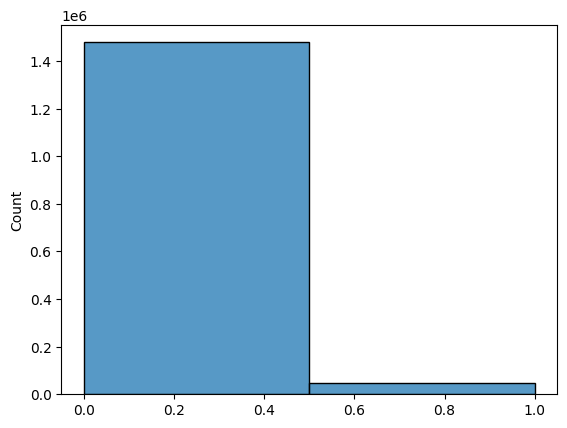

In [12]:
import seaborn as sns
sns.histplot(train_baseTable["target"], bins=2)

<p>We can see that accuracy is not appropriate here because of the highly imbalanced classes. If the model always predicts non-default classes it will always have 0.95 accuracy which is wrong, so AUC must be used in this case</p>

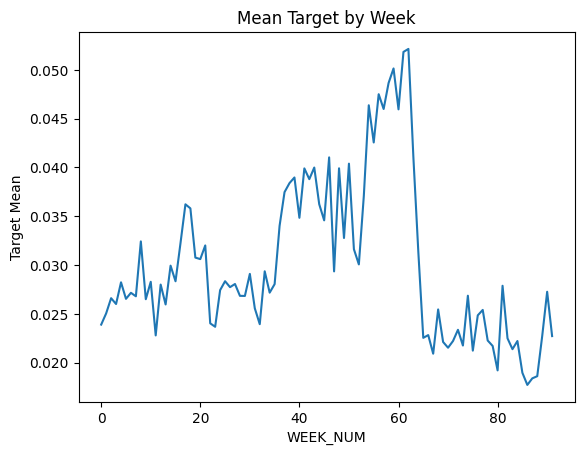

In [13]:
# Class imbalance and time drift
import matplotlib.pyplot as plt
pdf = (
    train_baseTable
    .group_by("WEEK_NUM")
    .agg(pl.col("target").mean().alias("target_mean"))
    .sort("WEEK_NUM")
    .to_pandas()
)
plt.plot(pdf["WEEK_NUM"], pdf["target_mean"])
plt.xlabel("WEEK_NUM")
plt.ylabel("Target Mean")
plt.title("Mean Target by Week")
plt.show()

<p>Early period: stable and low</p>
<p>Middle period: strong increase</p>
<p>Sudden drop somewhere in the middle</p>
<p>End: Stays low</p>
<p>Suggesting that there is a distribution shift</p>

In [14]:
def plot_missing_features(df):
    missing_rate = df.isnull().mean().sort_values(ascending=False)

    missing_rate.head(20).plot.barh()

## Centralised table paths 

In [15]:
from pathlib import Path

DATA_DIR = Path("home_credit_data/csv_files/train")

TABLES = {
    "base": DATA_DIR / "train_base.csv",
    "static_0_0": DATA_DIR / "train_static_0_0.csv",
    "static_0_1": DATA_DIR / "train_static_0_1.csv",
    "static_cb_0": DATA_DIR / "train_static_cb_0.csv",
    "person_1": DATA_DIR / "train_person_1.csv",
    "person_2": DATA_DIR / "train_person_2.csv",
    "applprev_1_0": DATA_DIR / "train_applprev_1_0.csv",
    "applprev_1_1": DATA_DIR / "train_applprev_1_1.csv",
    "applprev_2": DATA_DIR / "train_applprev_2.csv",
    "credit_bureau_a_1_0": DATA_DIR / "train_credit_bureau_a_1_0.csv",
    "credit_bureau_a_1_1": DATA_DIR / "train_credit_bureau_a_1_1.csv",
    "credit_bureau_a_1_2": DATA_DIR / "train_credit_bureau_a_1_2.csv",
    "credit_bureau_a_1_3": DATA_DIR / "train_credit_bureau_a_1_3.csv",
    "credit_bureau_a_2_0": DATA_DIR / "train_credit_bureau_a_2_0.csv",
    "credit_bureau_a_2_1": DATA_DIR / "train_credit_bureau_a_2_1.csv",
    "credit_bureau_a_2_2": DATA_DIR / "train_credit_bureau_a_2_2.csv",
    "credit_bureau_a_2_3": DATA_DIR / "train_credit_bureau_a_2_3.csv",
    "credit_bureau_a_2_4": DATA_DIR / "train_credit_bureau_a_2_4.csv",
    "credit_bureau_a_2_5": DATA_DIR / "train_credit_bureau_a_2_5.csv",
    "credit_bureau_a_2_6": DATA_DIR / "train_credit_bureau_a_2_6.csv",
    "credit_bureau_a_2_7": DATA_DIR / "train_credit_bureau_a_2_7.csv",
    "credit_bureau_a_2_8": DATA_DIR / "train_credit_bureau_a_2_8.csv",
    "credit_bureau_a_2_9": DATA_DIR / "train_credit_bureau_a_2_9.csv",
    "credit_bureau_a_2_10": DATA_DIR / "train_credit_bureau_a_2_10.csv",
    "credit_bureau_b_1": DATA_DIR / "train_credit_bureau_b_1.csv",
    "credit_bureau_b_2": DATA_DIR / "train_credit_bureau_b_2.csv",
    "debitcard_1": DATA_DIR / "train_debitcard_1.csv",
    "deposit_1": DATA_DIR / "train_deposit_1.csv",
    "other_1": DATA_DIR / "train_other_1.csv",
    "tax_registry_a_1": DATA_DIR / "train_tax_registry_a_1.csv",
    "tax_registry_b_1": DATA_DIR / "train_tax_registry_b_1.csv",
    "tax_registry_c_1": DATA_DIR / "train_tax_registry_c_1.csv",
}

## Check depth profiling

In [16]:
def table_schema(path):
    return pl.read_csv(path, n_rows=0).schema

def depth_stats(path):
    df = pl.scan_csv(path).select("case_id")

    return (
        df.group_by("case_id")
        .count()
        .select(
            pl.col("count").mean().alias("avg_rows_per_case"),
            pl.col("count").max().alias("max_rows_per_case"),
            pl.col("count").median().alias("median_rows_per_case")
        )
        .collect()  
        )

schema_map = {name: table_schema(path) for name, path in TABLES.items()}
depth_map = {name: depth_stats(path) for name, path in TABLES.items()}

schema_map["base"], depth_map["base"]

C:\Users\User\AppData\Local\Temp\ipykernel_4312\1605567424.py:9: DeprecationWarning: `count` was renamed; use `len` instead
  .count()


(Schema([('case_id', Int64),
         ('date_decision', String),
         ('MONTH', Int64),
         ('WEEK_NUM', Int64),
         ('target', Int64)]),
 shape: (1, 3)
 ┌───────────────────┬───────────────────┬──────────────────────┐
 │ avg_rows_per_case ┆ max_rows_per_case ┆ median_rows_per_case │
 │ ---               ┆ ---               ┆ ---                  │
 │ f64               ┆ u32               ┆ f64                  │
 ╞═══════════════════╪═══════════════════╪══════════════════════╡
 │ 1.0               ┆ 1                 ┆ 1.0                  │
 └───────────────────┴───────────────────┴──────────────────────┘)

In [17]:
# List out tables that can be safely joined/ aggregated/ dangerous to join

def categorize_tables(depth_map, dangerous_max_threshold=100, dangerous_avg_threshold=20):
    rows = []
    for name, stats_df in depth_map.items():
        avg_rows = float(stats_df["avg_rows_per_case"][0])
        med_rows = float(stats_df["median_rows_per_case"][0])
        max_rows = int(stats_df["max_rows_per_case"][0])

        # Categorization rules
        if max_rows == 1:
            category = "SAFE_JOIN"
        elif (max_rows >= dangerous_max_threshold) or (avg_rows >= dangerous_avg_threshold):
            category = "DANGEROUS"
        else:
            category = "MUST_AGG"

        rows.append({
            "table": name,
            "avg_rows_per_case": avg_rows,
            "median_rows_per_case": med_rows,
            "max_rows_per_case": max_rows,
            "category": category
        })

    summary = pl.DataFrame(rows).sort(["category", "max_rows_per_case"], descending=[False, True])
    return summary

summary = categorize_tables(depth_map, dangerous_max_threshold=100, dangerous_avg_threshold=20)
summary
 

table,avg_rows_per_case,median_rows_per_case,max_rows_per_case,category
str,f64,f64,i64,str
"""credit_bureau_a_2_6""",169.5939,132.0,9404,"""DANGEROUS"""
"""credit_bureau_a_2_7""",178.799405,132.0,7859,"""DANGEROUS"""
"""credit_bureau_a_2_5""",142.935178,96.0,5986,"""DANGEROUS"""
"""credit_bureau_a_2_3""",139.453298,96.0,4257,"""DANGEROUS"""
"""credit_bureau_a_2_2""",114.154068,72.0,4209,"""DANGEROUS"""
…,…,…,…,…
"""static_0_0""",1.0,1.0,1,"""SAFE_JOIN"""
"""base""",1.0,1.0,1,"""SAFE_JOIN"""
"""other_1""",1.0,1.0,1,"""SAFE_JOIN"""


In [18]:
safe_tables = summary.filter(pl.col("category") == "SAFE_JOIN")["table"].to_list()
must_agg_tables = summary.filter(pl.col("category") == "MUST_AGG")["table"].to_list()
dangerous_tables = summary.filter(pl.col("category") == "DANGEROUS")["table"].to_list()

print("SAFE to join (1:1):", safe_tables)
print("\nMUST aggregate (1:many):", must_agg_tables)
print("\nDANGEROUS (very high depth):", dangerous_tables)


SAFE to join (1:1): ['static_0_0', 'base', 'other_1', 'static_cb_0', 'static_0_1']

MUST aggregate (1:many): ['tax_registry_a_1', 'applprev_2', 'debitcard_1', 'deposit_1', 'person_2', 'credit_bureau_b_1', 'applprev_1_1', 'applprev_1_0', 'person_1']

DANGEROUS (very high depth): ['credit_bureau_a_2_6', 'credit_bureau_a_2_7', 'credit_bureau_a_2_5', 'credit_bureau_a_2_3', 'credit_bureau_a_2_2', 'credit_bureau_a_2_4', 'credit_bureau_a_2_9', 'credit_bureau_a_2_1', 'credit_bureau_a_2_8', 'credit_bureau_a_2_10', 'credit_bureau_a_2_0', 'credit_bureau_a_1_2', 'credit_bureau_b_2', 'credit_bureau_a_1_0', 'credit_bureau_a_1_1', 'credit_bureau_a_1_3', 'tax_registry_c_1', 'tax_registry_b_1']


In [19]:
def missingness_profile(path, top_n=20):
    df = pl.read_csv(path)
    return (
        df.select([
            (pl.col(c).null_count() / pl.len()).alias(c)
            for c in df.columns
        ])
        .transpose(include_header=True)
        .rename({"column": "feature", "column_0": "missing_rate"})
        .sort("missing_rate", descending=True)
        .head(top_n)
    )
missingness_profile(TABLES["base"])


feature,missing_rate
str,f64
"""case_id""",0.0
"""date_decision""",0.0
"""MONTH""",0.0
"""WEEK_NUM""",0.0
"""target""",0.0


C:\Users\User\AppData\Local\Temp\ipykernel_4312\2664852042.py:3: DeprecationWarning: `count` was renamed; use `len` instead
  counts = df.group_by("case_id").count().collect().to_pandas()


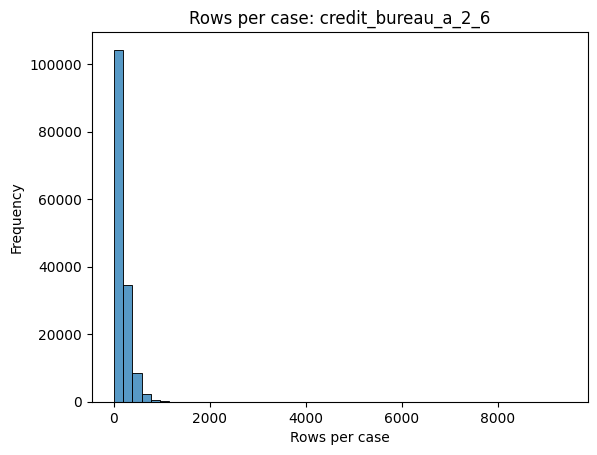

In [20]:
def row_count_distribution(path, title):
    df = pl.scan_csv(path).select("case_id")
    counts = df.group_by("case_id").count().collect().to_pandas()
    sns.histplot(counts["count"], bins=50)
    plt.title(title)
    plt.xlabel("Rows per case")
    plt.ylabel("Frequency")
    plt.show()

row_count_distribution(TABLES["credit_bureau_a_2_6"], "Rows per case: credit_bureau_a_2_6")


In [ ]:
# Split columns into numerical and categorical type
def split_cols(schema):
    num, cat = [], []
    for col, dtype in schema.items():
        if col=="case_id":
            continue
        if dtype in (pl.Int64, pl.Int32, pl.Float64, pl.Float32):
            num.append(col)
        else:
            cat.append(col)
    return num, cat

# aggregate to one records, excluded sum because maybe misleading for ratio columns
def agg_to_case(path, schema):
    num_cols, cat_cols = split_cols(schema)

    df = pl.scan_csv(path)
    aggs = []
    for c in num_cols:
        aggs +=[
            pl.col(c).min().alias(f"{c}_min"),
            pl.col(c).max().alias(f"{c}_max"),
            pl.col(c).mean().alias(f"{c}_mean")                        
        ]

    for c in cat_cols:
        aggs += [
            pl.col(c).n_unique().alias(f"{c}_nunique")
        ]
    aggs += [pl.count().alias("row_count")]
    return df.group_by("case_id").agg(aggs).collect()


def agg_person_split(df: pl.LazyFrame, numeric_cols: list[str], cat_cols: list[str]) -> pl.LazyFrame:
    # Applicant rows
    app = df.filter(pl.col("num_group1") == 0)
    # Other related persons
    rel = df.filter(pl.col("num_group1") != 0)

    def make_aggs(prefix: str):
        aggs = []
        for c in numeric_cols:
            aggs += [
                pl.col(c).min().alias(f"{prefix}{c}_min"),
                pl.col(c).max().alias(f"{prefix}{c}_max"),
                pl.col(c).mean().alias(f"{prefix}{c}_mean"),
            ]
        for c in cat_cols:
            aggs += [
                pl.col(c).n_unique().alias(f"{prefix}{c}_nunique"),
            ]
        aggs += [pl.count().alias(f"{prefix}row_count")]
        return aggs

    app_agg = app.group_by("case_id").agg(make_aggs("app_"))
    rel_agg = rel.group_by("case_id").agg(make_aggs("rel_"))

    # Join the two aggregated tables on case_id
    return app_agg.join(rel_agg, on="case_id", how="outer")


# Aggregate with time windows
def agg_with_time_windows(
    df: pl.LazyFrame,
    time_col: str,           
    base_dates: pl.DataFrame,  # case_id + date_decision
    numeric_cols: list[str],
    windows_years=(1, 3, 5),
):
    # Join base dates into the depth table
    df = df.join(base_dates.lazy(), on="case_id", how="left")

    # Parse date if needed then compute age in years (positive = past)
    df = df.with_columns(
        pl.col(time_col).str.strptime(pl.Date, strict=False).alias(time_col)
    ).with_columns(
        ((pl.col("date_decision") - pl.col(time_col)).dt.total_days() / 365.0).alias("age_years")
    )

    aggs_all = []
    # Overall (no window)
    for c in numeric_cols:
        aggs_all += [
            pl.col(c).max().alias(f"{c}_max_all"),
            pl.col(c).mean().alias(f"{c}_mean_all"),
        ]
    aggs_all += [pl.count().alias("row_count_all")]

    # Windowed
    for w in windows_years:
        in_win = pl.col("age_years").is_not_null() & (pl.col("age_years") <= w) & (pl.col("age_years") >= 0)
        for c in numeric_cols:
            aggs_all += [
                pl.col(c).filter(in_win).max().alias(f"{c}_max_le{w}y"),
                pl.col(c).filter(in_win).mean().alias(f"{c}_mean_le{w}y"),
            ]
        aggs_all += [pl.count().filter(in_win).alias(f"row_count_le{w}y")]

    return df.group_by("case_id").agg(aggs_all)

In [22]:
# Aggregate static_0_0', 'base', 'other_1', 'static_cb_0', 'static_0_1'
schema = schema_map["person_1"]
numeric_cols, cat_cols = split_cols(schema)

df = pl.scan_csv(TABLES["person_1"])
person_1_agg = agg_person_split(df, numeric_cols, cat_cols).collect()
person_1_agg.shape

static_0_0 = pl.read_csv(TABLES["static_0_0"])
static_0_1 = pl.read_csv(TABLES["static_0_1"])
static_cb_0 = pl.read_csv(TABLES["static_cb_0"])
other_1 = pl.read_csv(TABLES["other_1"])

merged = (
    train_baseTable
    .join(static_0_0, on="case_id", how="left")
    .join(static_0_1, on="case_id", how="left")
    .join(static_cb_0, on="case_id", how="left")
    .join(other_1, on="case_id", how="left")
    .join(person_1_agg, on="case_id", how="left")
)

merged.shape

C:\Users\User\AppData\Local\Temp\ipykernel_4312\3180966179.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  aggs += [pl.count().alias(f"{prefix}row_count")]
C:\Users\User\AppData\Local\Temp\ipykernel_4312\3180966179.py:59: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  return app_agg.join(rel_agg, on="case_id", how="outer")


(1526659, 496)

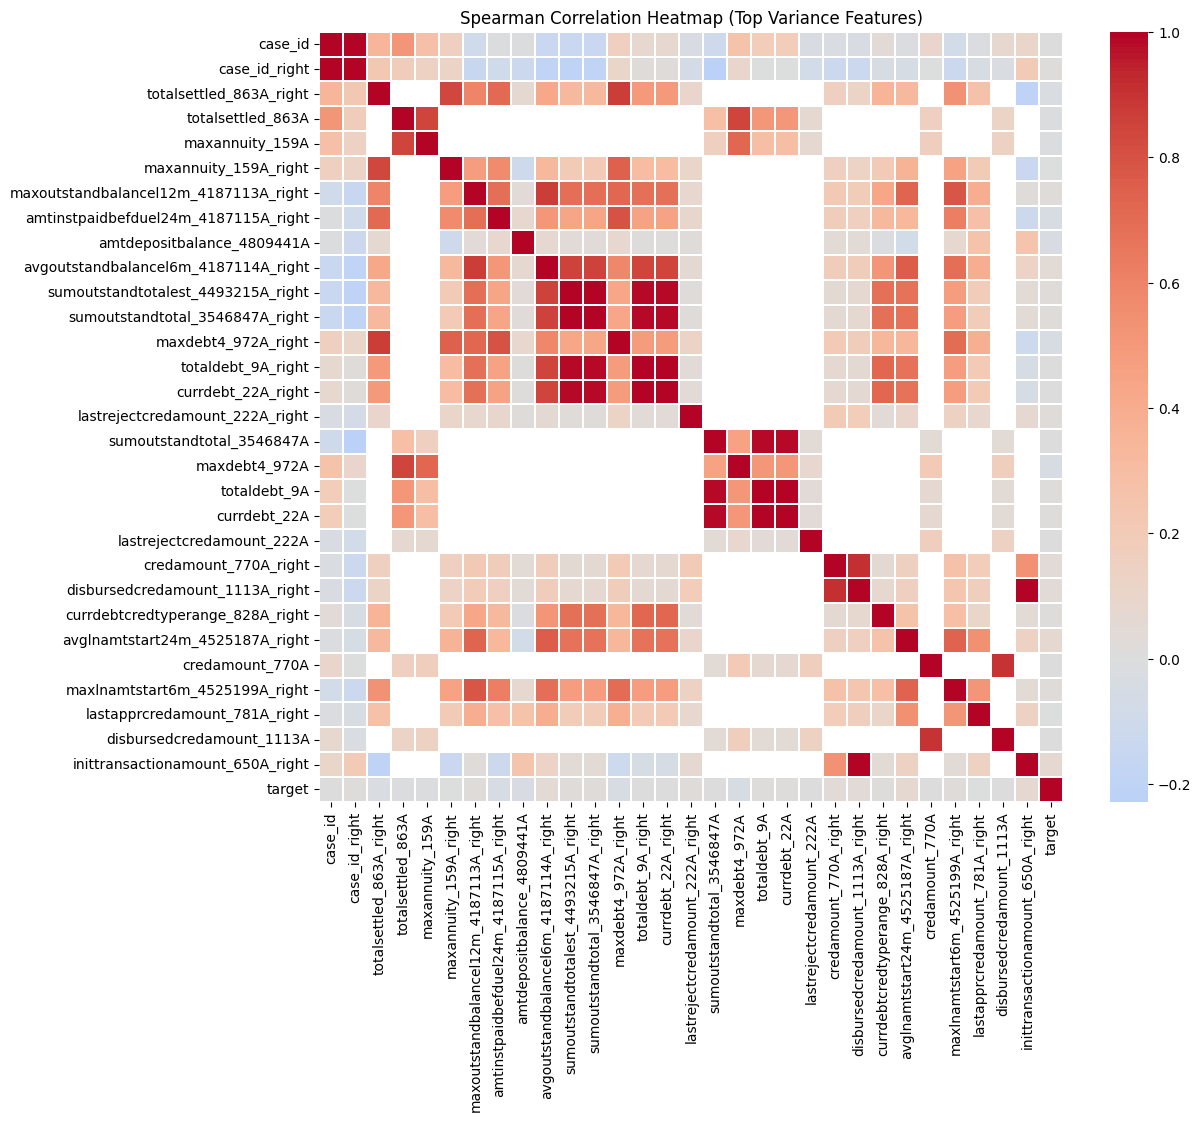

In [23]:
# Select numeric columns only
num_cols = [c for c in merged.columns if merged[c].dtype in (pl.Int64, pl.Int32, pl.Float64, pl.Float32) and c!="target"]
# Sample for plotting
pdf = merged.select(num_cols + ["target"]).sample(n=20000, seed=42).to_pandas()
# Reduce to top variance features to keep heatmap readable
variances = pdf[num_cols].var().sort_values(ascending=False)
top_cols = variances.head(30).index.tolist()

corr = pdf[top_cols + ["target"]].corr(method="spearman")

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Spearman Correlation Heatmap (Top Variance Features)")
plt.show()


## Spearman correlation heatmap
<p>Red: features are highly correlated</p>
<p>White: features are not correlated at all</p>

** need to drop case_id column

** Feature Engineering: Prune feature selections

## Plot features vs target

In [24]:
# Apply suffix-based typing, date parsing, and relative-time conversion to base tables
test_baseTable_typed = parse_date(convert_string_to_float(test_baseTable))
test_baseTable_typed = convert_relative_time(test_baseTable_typed)

merged_typed = parse_date(convert_string_to_float(merged))
merged_typed = convert_relative_time(merged_typed)
# Suffix consistency check (post-typing/parsing)
suffix_consistency_report(merged_typed)[:10]

[('WEEK_NUM', 'M', 'Int64', 'M should usually be string/categorical'),
 ('datefirstoffer_1144D', 'D', 'Float64', 'D should be Utf8 or Date/Datetime'),
 ('datelastinstal40dpd_247D',
  'D',
  'Float64',
  'D should be Utf8 or Date/Datetime'),
 ('datelastunpaid_3546854D',
  'D',
  'Float64',
  'D should be Utf8 or Date/Datetime'),
 ('dtlastpmtallstes_4499206D',
  'D',
  'Float64',
  'D should be Utf8 or Date/Datetime'),
 ('firstclxcampaign_1125D',
  'D',
  'Float64',
  'D should be Utf8 or Date/Datetime'),
 ('firstdatedue_489D', 'D', 'Float64', 'D should be Utf8 or Date/Datetime'),
 ('lastactivateddate_801D',
  'D',
  'Float64',
  'D should be Utf8 or Date/Datetime'),
 ('lastapplicationdate_877D',
  'D',
  'Float64',
  'D should be Utf8 or Date/Datetime'),
 ('lastapprdate_640D', 'D', 'Float64', 'D should be Utf8 or Date/Datetime')]

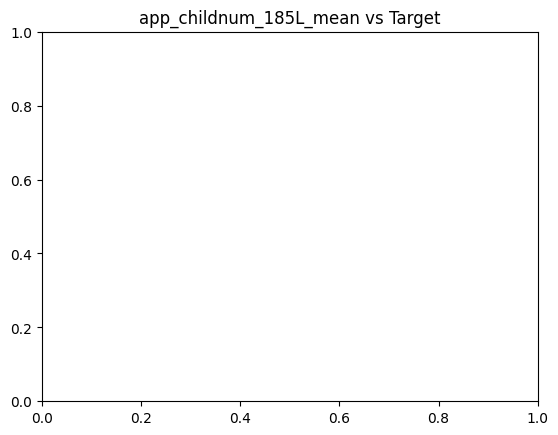

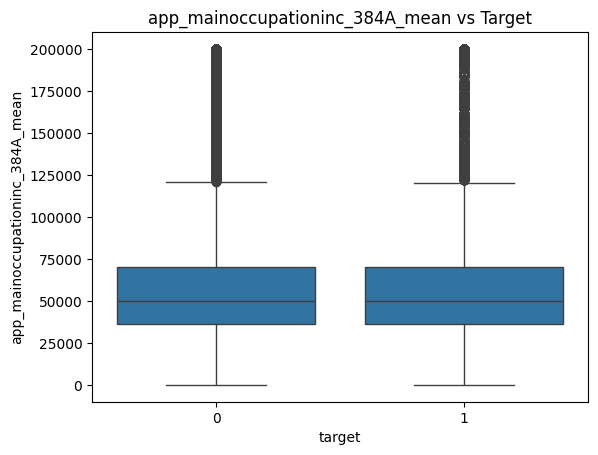

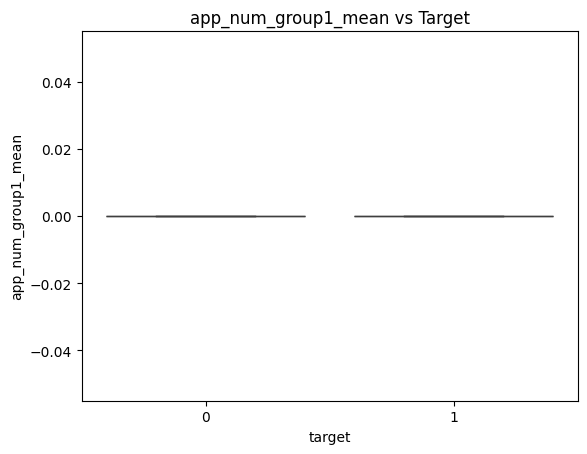

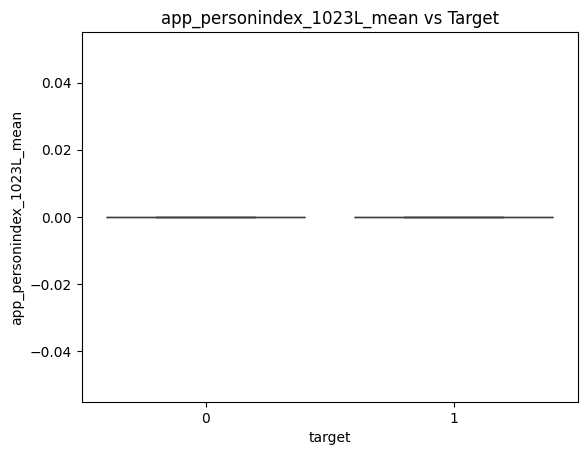

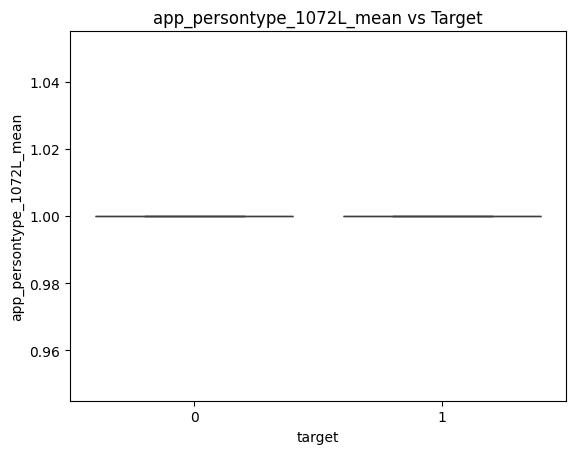

In [25]:
def plot_feature_vs_target(df, feature):
    pdf = df.select([feature, "target"]).drop_nulls().to_pandas()
    sns.boxplot(data=pdf, x="target", y=feature)
    plt.title(f"{feature} vs Target")
    plt.show()

candidate_features = [c for c in merged.columns if c.endswith("_mean")][:5]
for f in candidate_features:
    plot_feature_vs_target(merged, f)

In [26]:
merged.shape

(1526659, 496)

In [27]:
X = merged.drop(["case_id", "target"])
y = merged["target"]

In [28]:
from scipy.stats import ks_2samp

def ks_drift(train_df, test_df, cols, sample_n=20000):
    train_sample = train_df.sample(n=sample_n, seed=42).to_pandas()
    test_sample = test_df.sample(n=sample_n, seed=42).to_pandas()
    rows = []
    for c in cols:
        if c not in train_sample or c not in test_sample: 
            continue
        t = train_sample[c].dropna()
        s = test_sample[c].dropna()
        if len(t)==0 or len(s)==0: 
            continue
        stat, p = ks_2samp(t, s)
        rows.append((c, stat, p))
    return pd.DataFrame(rows, columns=["feature", "ks_stat", "p_value"]).sort_values("ks_stat", ascending=False)

base_num_cols = [c for c in merged_typed.columns if merged_typed[c].dtype in (pl.Int64, pl.Int32, pl.Float64, pl.Float32)]
drift_report = ks_drift(merged_typed, test_baseTable_typed, base_num_cols[:50])
drift_report.head(10)


ShapeError: cannot take a larger sample than the total population when `with_replacement=false`